In [ ]:
#| hide
!pip install -Uqq nixtla pyreadr

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from itertools import product
    from fastcore.test import test_eq, test_fail, test_warns
    from dotenv import load_dotenv  

# Bounded forecasts

In forecasting, we often want to make sure the predictions stay within a certain range. For example, for predicting the sales of a product, we may require all forecasts to be positive. Thus, the forecasts may need to be bounded.

With TimeGPT, you can create bounded forecasts by transforming your data prior to calling the forecast function.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/13_bounded_forecasts')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/13_bounded_forecasts.ipynb)

## 1. Import packages
First, we install and import the required packages

In [ ]:
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, set the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

We use the [annual egg prices](https://github.com/robjhyndman/fpp3package/tree/master/data) dataset from [Forecasting, Principles and Practices](https://otexts.com/fpp3/). We expect egg prices to be strictly positive, so we want to bound our forecasts to be positive. 

::: {.callout-note}
You can install `pyreadr` with `pip`:
    
```shell
pip install pyreadr
```
:::

In [ ]:
import pyreadr
from pathlib import Path

# Download and store the dataset
url = 'https://github.com/robjhyndman/fpp3package/raw/master/data/prices.rda'
dst_path = str(Path.cwd().joinpath('prices.rda'))
result = pyreadr.read_r(pyreadr.download_file(url, dst_path), dst_path)

In [ ]:
# Perform some preprocessing
df = result['prices'][['year', 'eggs']]
df = df.dropna().reset_index(drop=True)
df = df.rename(columns={'year':'ds', 'eggs':'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y')
df['unique_id'] = 'eggs'

df.tail(10)

,ds,y,unique_id
84,1984-01-01,100.58,eggs
85,1985-01-01,76.84,eggs
86,1986-01-01,81.10,eggs
87,1987-01-01,69.60,eggs
88,1988-01-01,64.55,eggs
89,1989-01-01,80.36,eggs
90,1990-01-01,79.79,eggs
91,1991-01-01,74.79,eggs
92,1992-01-01,64.86,eggs
93,1993-01-01,62.27,eggs


We can have a look at how the prices have evolved in the 20th century, demonstrating that the price is trending down.

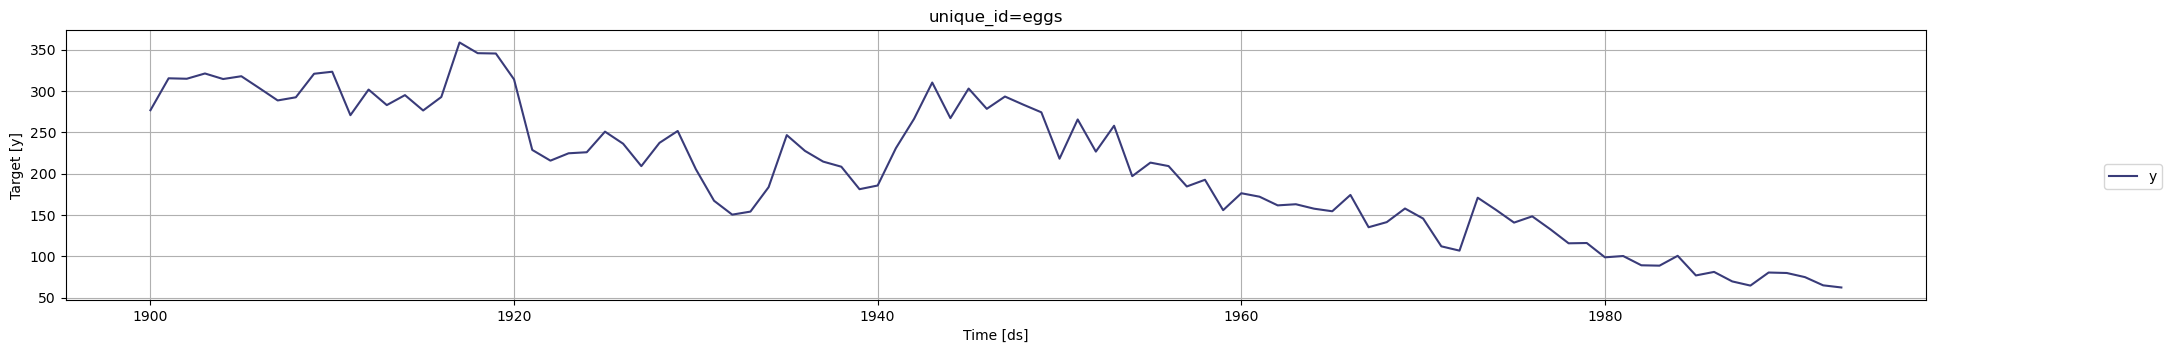

In [ ]:
nixtla_client.plot(df)

## 3. Bounded forecasts with TimeGPT

First, we transform the target data. In this case, we will log-transform the data prior to forecasting, such that we can only forecast positive prices.

In [ ]:
df_transformed = df.copy()
df_transformed['y'] = np.log(df_transformed['y'])

We will create forecasts for the next 10 years, and we include an 80, 90 and 99.5 percentile of our forecast distribution.

In [ ]:
timegpt_fcst_with_transform = nixtla_client.forecast(df=df_transformed, h=10, freq='Y', level=[80, 90, 99.5])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: AS-JAN
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

After having created the forecasts, we need to inverse the transformation that we applied earlier. With a log-transformation, this simply means we need to exponentiate the forecasts:

In [ ]:
cols_to_transform = [col for col in timegpt_fcst_with_transform if col not in ['unique_id', 'ds']]
for col in cols_to_transform:
    timegpt_fcst_with_transform[col] = np.exp(timegpt_fcst_with_transform[col])

Now, we can plot the forecasts. We include a number of prediction intervals, indicating the 80, 90 and 99.5 percentile of our forecast distribution.

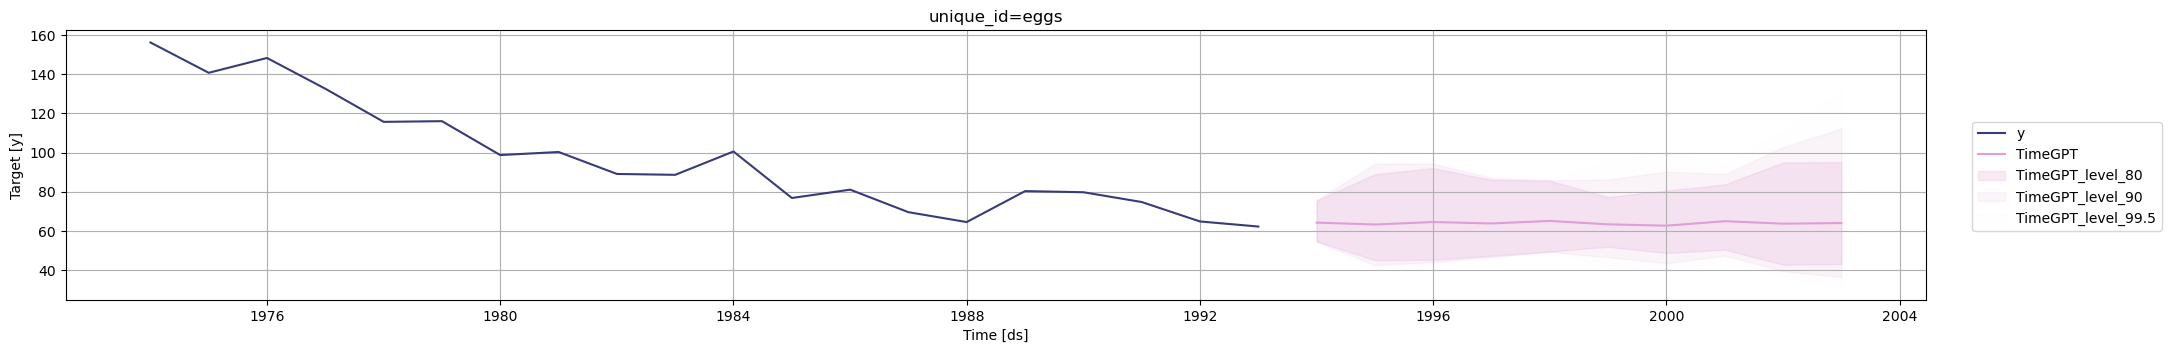

In [ ]:
nixtla_client.plot(
    df, 
    timegpt_fcst_with_transform, 
    level=[80, 90, 99.5],
    max_insample_length=20
)

The forecast and the prediction intervals look reasonable.

Let's compare these forecasts to the situation where we don't apply a transformation. In this case, it may be possible to forecast a negative price.

In [ ]:
timegpt_fcst_without_transform = nixtla_client.forecast(df=df, h=10, freq='Y', level=[80, 90, 99.5])

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: AS-JAN
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Indeed, we now observe prediction intervals that become negative:

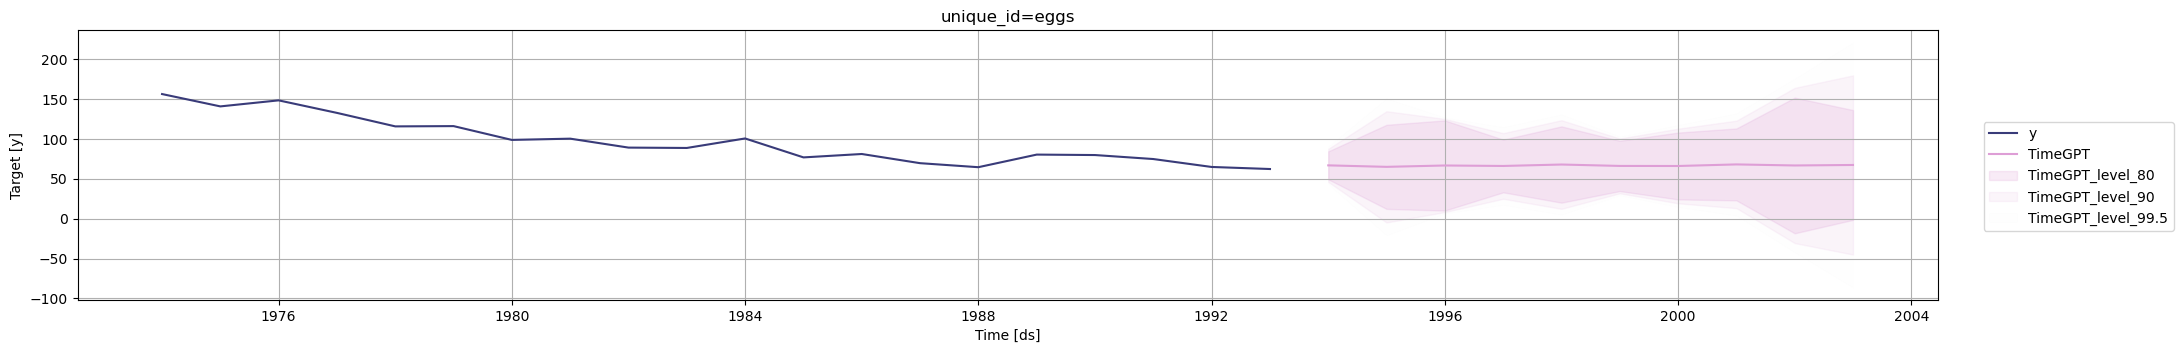

In [ ]:
nixtla_client.plot(
    df, 
    timegpt_fcst_without_transform, 
    level=[80, 90, 99.5],
    max_insample_length=20
)

For example, in 1995:

In [ ]:
timegpt_fcst_without_transform

,unique_id,ds,TimeGPT,TimeGPT-lo-99.5,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-99.5
0,eggs,1994-01-01,66.859756,43.103240,46.131448,49.319034,84.400479,87.588065,90.616273
1,eggs,1995-01-01,64.993477,-20.924112,-4.750041,12.275298,117.711656,134.736995,150.911066
2,eggs,1996-01-01,66.695808,6.499170,8.291150,10.177444,123.214173,125.100467,126.892446
3,eggs,1997-01-01,66.103325,17.304282,24.966939,33.032894,99.173756,107.239711,114.902368
4,eggs,1998-01-01,67.906517,4.995371,12.349648,20.090992,115.722042,123.463386,130.817663
5,eggs,1999-01-01,66.147575,29.162207,31.804460,34.585779,97.709372,100.490691,103.132943
6,eggs,2000-01-01,66.062637,14.671932,19.305822,24.183601,107.941673,112.819453,117.453343
7,eggs,2001-01-01,68.045769,3.915282,13.188964,22.950736,113.140802,122.902573,132.176256
8,eggs,2002-01-01,66.718903,-42.212631,-30.583703,-18.342726,151.780531,164.021508,175.650436
9,eggs,2003-01-01,67.344078,-86.239911,-44.959745,-1.506939,136.195095,179.647901,220.928067


This demonstrates the value of the log-transformation to obtain bounded forecasts with TimeGPT, which allows us to obtain better calibrated prediction intervals.

**References**

* [Hyndman, Rob J., and George Athanasopoulos (2021). "Forecasting: Principles and Practice (3rd Ed)"](https://otexts.com/fpp3/)


